## Introduction to Recurrent Neural Networks

First, let's start with a toy example. The dataset is comprised of two sentences. Let's train a simple recurrent neural network to predict words.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import inspect
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
#import reader
import collections
import os
import re
import json

import matplotlib.pyplot as plt
!nvidia-smi

Wed May 10 20:05:54 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.57                 Driver Version: 367.57                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000:00:1E.0     Off |                    0 |
| N/A   50C    P8    26W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
tf.reset_default_graph()
a=np.array([[1,2,3,4,5,0],[1,2,3,4,6,0]]) 
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        result=tf.nn.embedding_lookup(np.identity(10), a).eval()
        example_input=sess.run([tf.unstack(result,6,1)])
        coord.request_stop()
        coord.join(threads)
        sess.close()
print('one-hot encoded inputs')
print(result)
print('shape of the input')
print(result.shape)
print('reshaped input for training')
print(example_input)



one-hot encoded inputs
[[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]]
shape of the input
(2, 6, 10)
reshaped input for training
[[array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]]), array([[ 0.,  0.,  0.,  0

Create a single layer RNN with LSTMs and train it with a toy dataset. 

In [3]:
plot_loss=[]
num_hidden=24
num_steps=6
dict_length=8
batch_size=2
tf.reset_default_graph()

## Make Variables
variables_dict = {
    "weights1":tf.Variable(tf.truncated_normal([num_hidden,dict_length],stddev=1.0,dtype=tf.float32),name="weights1"),
    "biases1": tf.Variable(tf.truncated_normal([dict_length],stddev=1.0,dtype=tf.float32), name="biases1")}


# Create input data
small_dict=['EOS','i','will','walk','the','dog','cat','run']
X=np.array([[1,2,7,4,5,0],[1,2,3,4,6,0]],dtype=np.int32)  
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), X) #[batch,num_steps,dictionary_length][2,6,7]
y=np.zeros((batch_size,num_steps),dtype=np.int32)
y[:,:-1]=X[:,1:]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), y),num_steps,1) #[batch,num_steps,dictionary_length][2,6,7]

y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])

#Create our LSTM
cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)

outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
pred=tf.matmul(output_reshape, variables_dict["weights1"]) +variables_dict["biases1"]
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)


init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)        
        for i in range(300):
            loss,_,y_target,y_pred,output=sess.run([cost,optimizer,y_target_reshape,pred,outputs])
            plot_loss.append([loss])

            if i% 25 ==0:
                print("iteration: ",i," loss: ",loss)
                
        print(y_target)
        print(np.argmax(y_pred,1))          
        coord.request_stop()
        coord.join(threads)
        sess.close()    


iteration:  0  loss:  2.50325
iteration:  25  loss:  0.728643
iteration:  50  loss:  0.148765
iteration:  75  loss:  0.121297
iteration:  100  loss:  0.118705
iteration:  125  loss:  0.117768
iteration:  150  loss:  0.117226
iteration:  175  loss:  0.116867
iteration:  200  loss:  0.116615
iteration:  225  loss:  0.11643
iteration:  250  loss:  0.11629
iteration:  275  loss:  0.116182
[[ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]]
[2 2 7 7 4 4 5 6 0 0 0 0]


In [4]:
#Lets look at one input data point at each step and its prediction
print("Input Sentence")
print([small_dict[ind] for ind in X[0,:]])
print("Predicted words")
print([small_dict[ind] for ind in np.argmax(y_pred[0::2],1)])


Input Sentence
['i', 'will', 'run', 'the', 'dog', 'EOS']
Predicted words
['will', 'run', 'the', 'dog', 'EOS', 'EOS']


Now we are going to increase the depth of our RNN. Let's train an RNN with 2 and 4 layers. What parameter do you need to set to change the number of layers in your RNN? For a hint look [here](#answer1 "num_layers=2 or num_layer=4").

Where do you enter the dropout values for the RNN?  For a hint look [here](#answer2 "lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,input_keep_prob=input_keep_prob,output_keep_prob=output_keep_prob)").                         

In [6]:
#Now let's try multiple layers 
plot_loss2=[]
num_hidden=24
num_steps=6
dict_length=8
batch_size=2
num_layers=2
tf.reset_default_graph()

## Make Variables
variables_dict = {
    "weights1":tf.Variable(tf.truncated_normal([num_hidden,dict_length],stddev=1.0,dtype=tf.float32),name="weights1"),
    "biases1": tf.Variable(tf.truncated_normal([dict_length],stddev=1.0,dtype=tf.float32), name="biases1")}


# Create input data
small_dict=['EOS','i','will','walk','the','dog','cat','run']
X=np.array([[1,2,7,4,5,0],[1,2,3,4,6,0]],dtype=np.int32)  
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), X) #[batch,num_steps,dictionary_length][2,6,7]
y=np.zeros((batch_size,num_steps),dtype=np.int32)
y[:,:-1]=X[:,1:]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), y),num_steps,1) #[batch,num_steps,dictionary_length][2,6,7]
y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])

input_keep_prob=1.0#input_keep_prob,
output_keep_prob=1.0#output_keep_pro

##################### Create a multilayer RNN ####################
layer_cell=[]
for _ in range(num_layers):
    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
    lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=input_keep_prob,
                                          output_keep_prob=output_keep_prob)
    layer_cell.append(lstm_cell)

cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
pred=tf.matmul(output_reshape, variables_dict["weights1"]) +variables_dict["biases1"]

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)


init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        for i in range(300):
            loss,_,y_target,y_pred,output=sess.run([cost,optimizer,y_target_reshape,pred,outputs])
            plot_loss2.append([loss])
            
            if i% 25 ==0:
                print("iteration: ",i," loss: ",loss)
                
        print(y_target)
        print(np.argmax(y_pred,1))         
        coord.request_stop()
        coord.join(threads)
        sess.close()    


iteration:  0  loss:  2.62829
iteration:  25  loss:  0.996458
iteration:  50  loss:  0.19019
iteration:  75  loss:  0.120728
iteration:  100  loss:  0.117841
iteration:  125  loss:  0.117149
iteration:  150  loss:  0.116771
iteration:  175  loss:  0.116522
iteration:  200  loss:  0.116346
iteration:  225  loss:  0.116215
iteration:  250  loss:  0.116113
iteration:  275  loss:  0.116032
[[ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]]
[2 2 7 7 4 4 5 6 0 0 0 0]


#### Compare the loss from our single and multi-layer RNN. 

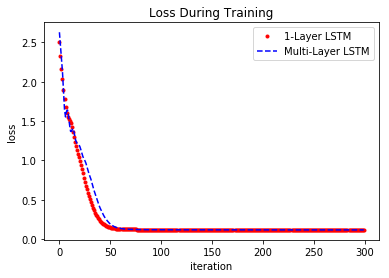

In [8]:
## import matplotlib.pyplot as plt
plt.plot(plot_loss,'r.')
plt.plot(plot_loss2,'b--')
plt.legend(["1-Layer LSTM","Multi-Layer LSTM"])
plt.ylabel("loss")
plt.xlabel("iteration")
plt.title("Loss During Training")
plt.show()

### Train an RNN with MSCOCO Captions 
Now we are going to try a slightly more complicated example. Let's use the [Microsoft Common Objects in Context](http://mscoco.org/) (MSCOCO) image captions to train an RNN. The cell below shows one way to read, format, and feed the data into TensorFlow. First, we will read the caption file, then we will remove the punctuation, and then train. Due to time constraints, we won't use the full dataset for this training. However, it would be easy to change this and train with more or the entire dataset. Can you see an easy way to do this?

In [9]:
num_steps=20
## Read Training files
with open("/data/mscoco/captions_train2014.json") as data_file:
         data=json.load(data_file)

TotalNumberofCaptions=len(data['annotations'])

sentences=[]

##Create a list of all of the sentences.
for i in range(TotalNumberofCaptions):
        sentences+=[re.sub('[^A-Za-z0-9]+',' ',data['annotations'][i]['caption']).lower()]

TotalWordList=[]
for i in range(TotalNumberofCaptions):
        TotalWordList+=re.sub('[^A-Za-z0-9]+',' ',data['annotations'][i]['caption']).lower().split()

#Determine number of distint words 
distintwords=collections.Counter(TotalWordList)
#Order words 
count_pairs = sorted(distintwords.items(), key=lambda x: (-x[1], x[0])) #ascending order
words, occurence = list(zip(*count_pairs))
DictionaryLength=occurence.index(4) #index for words that occur 4 times or less
words=['PAD','UNK','EOS']+list(words[:DictionaryLength])
word_to_id=dict(zip(words, range(len(words))))
#Tokenize Sentence
Tokenized=[]
for full_words in sentences:
        EmbeddedSentence=[word_to_id[word] for word in full_words.split() if word in word_to_id]+[word_to_id['EOS']]
        #Pad sentences that are shorter than the number of steps 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']]*num_steps
            b[:len(EmbeddedSentence)]=EmbeddedSentence
        if len(EmbeddedSentence)>num_steps:
            b=EmbeddedSentence[:num_steps]
        if len(b)==EmbeddedSentence:
            b=EmeddedSentence
        b=[word_to_id['UNK'] if x>=DictionaryLength else x for x in b] #turn all words used 4 times or less to 'UNK'
        #print(b)
        Tokenized+=[b]

In [10]:
print(sentences[:10])
print(Tokenized[:10])

[u'a very clean and well decorated empty bathroom', u'a panoramic view of a kitchen and all of its appliances ', u'a blue and white bathroom with butterfly themed wall tiles ', u'a panoramic photo of a kitchen and dining room', u'a graffiti ed stop sign across the street from a red car ', u'a vandalized stop sign and a red beetle on the road', u'a bathroom with a border of butterflies and blue paint on the walls above it ', u'an angled view of a beautifully decorated bathroom ', u'the two people are walking down the beach ', u'a sink and a toilet inside a small bathroom ']
[[3, 142, 508, 9, 619, 415, 276, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 4027, 171, 5, 3, 61, 9, 317, 5, 155, 612, 2, 0, 0, 0, 0, 0, 0, 0, 0], [3, 59, 9, 21, 57, 8, 2922, 1963, 136, 1225, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 4027, 162, 5, 3, 61, 9, 461, 43, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 638, 6775, 148, 58, 241, 6, 24, 96, 3, 47, 128, 2, 0, 0, 0, 0, 0, 0, 0], [3, 2539, 148, 58, 9, 3, 47, 7524, 4, 6, 84, 2, 

In [11]:
############################################# Parameters #####################################################

num_hidden=256
num_steps=20
dict_length=len(words)
batch_size=4
num_layers=1

## Create labels
Label=[]
for caption in Tokenized:
    Label+=[caption[1:]+[word_to_id['PAD']]]

NumberofCasestoEvaluate=20
TrainingInputs=Tokenized[:NumberofCasestoEvaluate]
LabelInputs=Label[:NumberofCasestoEvaluate]

#Print out some variables 
print(TrainingInputs[0])
print(LabelInputs[0])
print("Number of words in this dictionary ", len(words))

[3, 142, 508, 9, 619, 415, 276, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[142, 508, 9, 619, 415, 276, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of words in this dictionary  8768


In [12]:
#Create our input queue
def data_input_queue(TrainingInputs, LabelInputs, num_steps):
    train_input_queue = tf.train.slice_input_producer(
                                    [TrainingInputs, LabelInputs],
                                    shuffle=True)

    ##Set our train data and label input shape for the queue
    TrainingInput=train_input_queue[0]
    LabelInput=train_input_queue[1]
    TrainingInput.set_shape([num_steps])
    LabelInput.set_shape([num_steps])
    min_after_dequeue=100000
    capacity = min_after_dequeue + 3 * batch_size 
    #input_x, target_y
    train_x, train_y = tf.train.batch([TrainingInput, LabelInput],
                                                 batch_size=batch_size ,
                                                 capacity=capacity,
                                                 num_threads=4)
    return train_x, train_y

Now you are ready to train an RNN with the MSCOCO captions. Before you start training define the dropout values you want to use for training. If you need a hint check [here](#answer3 "Any value greater than 0 and less than or equal to 1 will work. For exampe input_keep_prob=1.0 and output_keep_prob=1.0 can be used").

In [13]:
tf.reset_default_graph()

loss_mscoco=[]
#######################################################################################################
NumberofCasestoEvaluate=100
TrainingInputs=Tokenized[:NumberofCasestoEvaluate]
LabelInputs=Label[:NumberofCasestoEvaluate]


## Make Variables
# tf Graph input
x = tf.placeholder(dtype=tf.int32, shape=(batch_size , num_steps))
y = tf.placeholder(dtype=tf.int32, shape=(batch_size,  num_steps))
#tf.get_variable_scope().reuse_variables()

variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


# Create input data
train_x, train_y =data_input_queue(TrainingInputs, LabelInputs, num_steps)
mscoco_dict=words
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), x) #[batch,num_steps,dictionary_length][2,6,7]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), y),num_steps,1) #[batch,num_steps,dictionary_length][2,6,7]
y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])

input_keep_prob=1.0
output_keep_prob=1.0

#Create a multilayer RNN

layer_cell=[]
for _ in range(num_layers):
    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
    ############# add dropout #########################
    lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=input_keep_prob,
                                          output_keep_prob=output_keep_prob)
    layer_cell.append(lstm_cell)

cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=lstm_cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
pred=tf.matmul(output_reshape, variables_dict["weights_mscoco"]) +variables_dict["biases_mscoco"]
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost,aggregation_method = tf.AggregationMethod.EXPERIMENTAL_TREE)


init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for i in range(1500):
            x_input,y_input=sess.run([train_x, train_y])
            loss,_,y_target,y_pred=sess.run([cost,optimizer,y_target_reshape,pred],feed_dict={x:x_input,y:y_input})
            loss_mscoco.append([loss])
            if i% 100==0:
                print("iteration: ",i, "loss: ",loss)  
        print("Done Training")
        coord.request_stop()
        coord.join(threads)
        sess.close()    

iteration:  0 loss:  9.11365
iteration:  100 loss:  0.596196
iteration:  200 loss:  0.330111
iteration:  300 loss:  0.195806
iteration:  400 loss:  0.156069
iteration:  500 loss:  0.166281
iteration:  600 loss:  0.262709
iteration:  700 loss:  0.0812796
iteration:  800 loss:  0.174823
iteration:  900 loss:  0.184339
iteration:  1000 loss:  0.220383
iteration:  1100 loss:  0.136037
iteration:  1200 loss:  0.192143
iteration:  1300 loss:  0.0695722
iteration:  1400 loss:  0.145747
Done Training


In [14]:
#Lets look at one input data point and its prediction
print("Input Sentence")
batch_element=2
print([words[ind] for ind in x_input[batch_element,:]])
print("Target")
print([words[ind] for ind in y_input[batch_element,:]])
print("Predicted words")
print([words[ind] for ind in np.argmax(y_pred[batch_element::batch_size],1)])

Input Sentence
[u'a', u'crisp', u'neutral', u'bathroom', u'embellished', u'with', u'modern', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Target
[u'crisp', u'neutral', u'bathroom', u'embellished', u'with', u'modern', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Predicted words
[u'man', u'neutral', u'bathroom', u'embellished', u'with', u'modern', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


Does the single word prediction cell above represent a deployment scenario? 

No, the ground truth is being propagated through the network. The  predicted caption above represents a single predicted word based on the previous ground truth.

In the classification part we had a function for our network. If you were going to make a function for this network, what would you include?  What would your inputs and outputs be?

In [ ]:
#Free our GPU memory before proceeding to the next part of the lab
import os
os._exit(00)

## References 
[1] Imanol Schlab. TensorFLow Input Pipeline Example. http://ischlag.github.io/2016/06/19/tensorflow-input-pipeline-example/

[2] Denny Britz. Practical Examples for RNNs in TensorFlow https://github.com/dennybritz/tf-rnn

[3]Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." European Conference on Computer Vision. Springer International Publishing, 2014.